This is my recreation of the notebook from Lesson 1 of the Fast.ai course. This is based on [Is it a bird? Creating a model from your own data](https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data). I chose to run this on a Jupyter notebook locally on my Mac, with a different example > Is it a bicycle?

# Step 0: Setup environment and Download packages

In [1]:
import os
! pip install fastai duckduckgo_search fastbook # everything after the "!" is a command that is run in the terminal.

# Step 1: Download images

In [2]:
# from duckduckgo_search import ddg_images
from fastbook import search_images_ddg
from fastbook import search_images_bing # to support Azure bing search
# from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return search_images_ddg(term, max_images=max_images)

In [3]:
# Search for images
urls = search_images('road bike', max_images=1)
urls[0]

# Click on the URL to check-it out.

Searching for 'road bike'


'https://www.dmarge.com/wp-content/uploads/2021/06/Road-Bike-Featured-Image-920x613.jpg'

Now that we have a URL, we need to download the image and take a look at it.

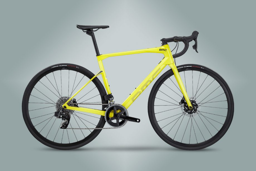

In [4]:
from fastdownload import download_url
dest = 'road_bike.jpg'
download_url(urls[0], dest, show_progress=True)

from fastai.vision.all import *
im= Image.open(dest)
im.to_thumb(256,256)

What should the model contrast it with, we could go with car, truck or motorbike.. but let's give it something trickier. Let's see how it does with Mountain bikes.

Searching for 'mountain bike'


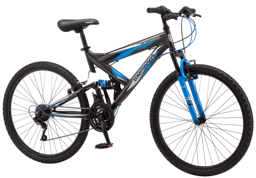

In [5]:
download_url(search_images('mountain bike', max_images=1)[0], 'mountain_bike.jpg', show_progress=True)
Image.open('mountain_bike.jpg').to_thumb(256,256)

Not bad. We're getting decent results. Let's grab a few more examples. We want to get 10 examples of each type of bicycle and put the results in it's own folder.

## Step 1.1: Download images

In [6]:
from pathlib import Path

searches = 'road bike', 'mountain bike'
path = Path('image_examples')
from time import sleep


for o in searches:
    dest = (path/o) # sets the destination folder for the images. E.g image_examples/road_bike.
    dest.mkdir(exist_ok=True, parents=True) # make the directory if it doesn't exist.
    # download_url(search_images(f'{o} photo', max_images=5), dest, show_progress=True)
    download_images(dest, urls=search_images(f'{o} photo')) # this function comes from the fastai.vision.utils module
    sleep(10)
    download_images(dest, urls=search_images(f'{o} in the rain'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} in the sun'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} being ridden'))
    resize_images(path/o, max_size=400, dest=path/o)



Searching for 'road bike photo'
Searching for 'road bike in the rain'


KeyboardInterrupt: 

In [ ]:
#hide
# delete downloaded images
! rm -rf image_examples

# Step 2: Train the model

Some photos may not have downloaded correctly - we should remove them.

In [ ]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

1

A `DataLoaders` object is required to train a model. We can create this using a `DataBlock` and the accompanying `dataloaders` method.

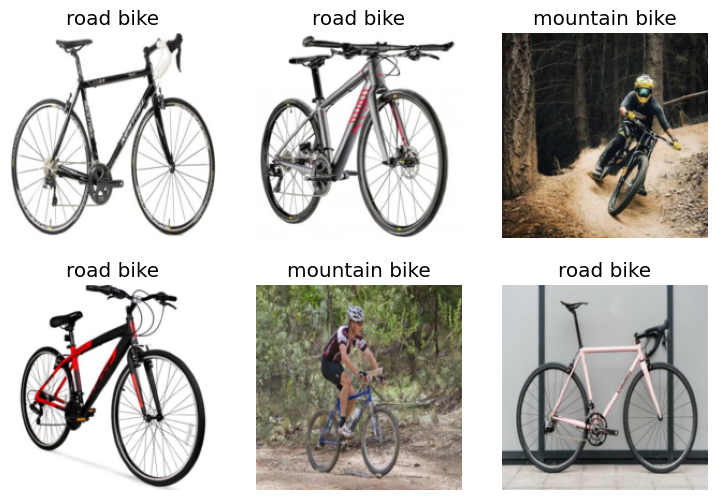

In [ ]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32) 

dls.show_batch(max_n=6)



The path variable (set earlier) is being used as an input into the dataloaders method for the DataBlock.

`blocks=(ImageBlock, CategoryBlock)`
Image Block are the images, Category Block are the categories (road bike and mountain bike). These come from the sub folders in the Path.

`get_items=get_image_files` the `get_image_files` function is used to retrieve all images in a path as input.

`splitter=RandomSplitter(valid_pct=0.2, seed=42)` Randomly splits the data into training and validation. 20% us used for validation. See is a randomness parameter.

`get_y=parent_label` The labels / categories / `y` values is the name of the parent folder of each file.

`item_tfms=[Resize(192, method='squish')]` Resize image to 192x192 using the "squish" method.

Now we can train the model - or more specifically. Fine Tune a pre-trained model.

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.086496,1.689483,0.488889,00:09


epoch,train_loss,valid_loss,error_rate,time
0,0.712933,1.480228,0.488889,00:02
1,0.642841,1.841279,0.422222,00:01
2,0.493566,1.844009,0.422222,00:01


The error_rate is a lot higher than expected.

# Step 3: Testing the model

Let's give the model a go. Let's try a few more pictures that we manually source from the web.

In [ ]:
# Test 1: Road Bike
what_bike,pred_idx,probs = learn.predict(PILImage.create('road_bike.jpg'))

print(f"Predicted class: {what_bike}")
print(f"Predicted class index: {pred_idx}")
print(f"Prediction outputs: {probs}")
print(f"I can say with a probability of: {probs[0]:.4f} that this is a: {what_bike}.")

Predicted class: road bike
Predicted class index: 1
Prediction outputs: tensor([0.0201, 0.9799])
I can say with a probability of: 0.0201 that this is a: road bike.


In [ ]:
# Test 2: Mountain Bike
what_bike,pred_idx,probs = learn.predict(PILImage.create('mountain_bike.jpg'))

print(f"Predicted class: {what_bike}")
print(f"Predicted class index: {pred_idx}")
print(f"Prediction outputs: {probs}")
print(f"I can say with a probability of: {probs[0]:.4f} that this is a: {what_bike}.")

Predicted class: mountain bike
Predicted class index: 0
Prediction outputs: tensor([0.9195, 0.0805])
I can say with a probability of: 0.9195 that this is a: mountain bike.


In [ ]:
# Test 3: Car - let's try to break it.
what_bike,pred_idx,probs = learn.predict(PILImage.create('car.jpg'))

print(f"Predicted class: {what_bike}")
print(f"Predicted class index: {pred_idx}")
print(f"Prediction outputs: {probs}")
print(f"I can say with a probability of: {probs[0]:.4f} that this is a: {what_bike}.")

Predicted class: road bike
Predicted class index: 1
Prediction outputs: tensor([0.0899, 0.9101])
I can say with a probability of: 0.0899 that this is a: road bike.


After running a few tests, the model has gotten the prediction right every time. What is strange is that the probability when predicting a mountain bike is always closer to 1.0 and when it's a road bike. It's closer to 0. 

In [ ]:
#hide
help(download_images)

# ! ls -l image_examples/road_bike | wc -l

# %pdef fastai.download_images
print(inspect.getsource(download_images))


# More Experiments
These experiments are from Chapter 2 of the book.

## Setting up Bing Search API
Sign up for a Microsoft Azure account for free. 
- Select the pay as you go option
- Once set up, you will need to set up an Azure Subscription and Azure Resource group
- Select the bing_resource service and deploy a new service
- No spaces in the resource name or you will run into a name error.

In [ ]:
# This is a test using DDG to search for bear pictures. Noticed that the no. of search results isn't as high. 
bear_types = 'grizzly', 'black', 'teddy'
path = Path('bears')

from time import sleep

for o in bear_types:
    dest = (path/o) # sets the destination folder for the images. E.g image_examples/road_bike.
    dest.mkdir(exist_ok=True, parents=True) # make the directory if it doesn't exist.
    download_images(dest, urls=search_images(f'{o} bears')) 
    

Searching for 'grizzly bears'
Searching for 'black bears'
Searching for 'teddy bears'


Once setup. Go to the [KeySetting - Microsoft Azure](https://portal.azure.com/#view/Microsoft_Bing_Api/KeySetting.ReactView/id/%2Fsubscriptions%2Faead6840-0ebf-4add-9bcf-14645efb30b5%2FresourceGroups%2Ffastai%2Fproviders%2FMicrosoft.Bing%2Faccounts%2Fbing_search) for the bing_search resource. Copy one of the keys to clipboard.

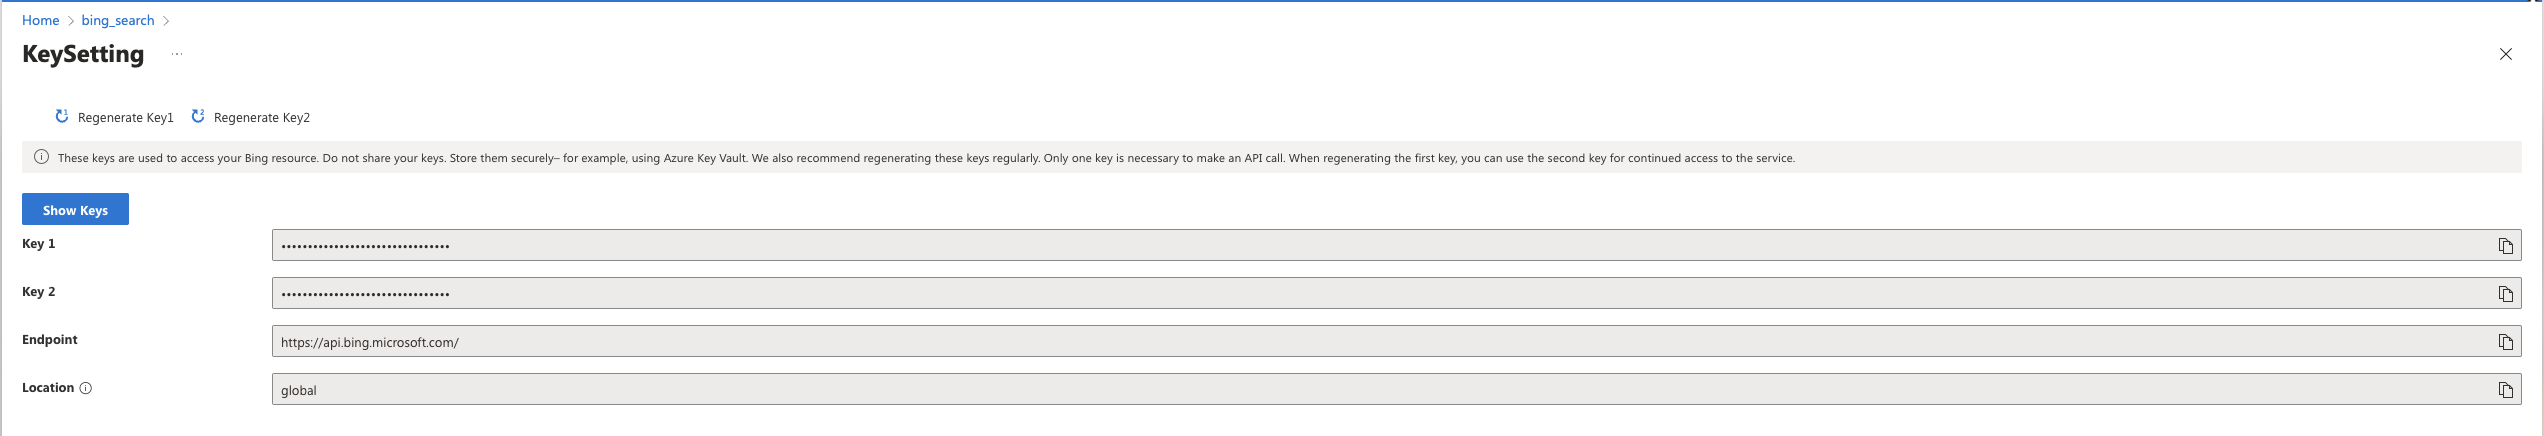

In [7]:
# Paste the key below. This is not best practice. This the key should be stored more securely. NEED TO WORK THIS OUT NEXT
key = os.environ.get('AZURE_SEARCH_KEY', '56d24274d17f41b89745fcdd4894ad59')

Let's give this a go.

In [8]:
results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('contentUrl')
len(ims)

150

We're getting some search results. 150 URLS to grizzly bear images from Bing Image Search.

Let's check one out.

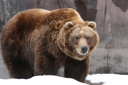

In [ ]:
dest = 'bears/grizzly.jpg'
download_url(ims[0], dest)
im = Image.open(dest)
im.to_thumb(128,128)

It's a bear! This seems to ahve worked nicely. We can now use `download_images` to download all the URLs for three search terms. We want to look for:
1. Grizzly Bears
2. Black Bears
3. Teddy Bears

In [22]:
bear_types = 'grizzly', 'black', 'teddy'
path = Path('bears')

if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))

Check if your images have downloaded as expected. Remember to also check for corrupted images and remove them.

In [24]:
failed = verify_images(get_image_files(path))
len(failed.map(Path.unlink))

0

## Train the model
With our image data downloaded, we can now start training the model. We will use `DataLoaders` again - same as before.

In [25]:
# Create the DataBlock.
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128)
)

In [26]:
dls = bears.dataloaders(path) # this creates a DataLoaders object from the datablock template using the path 'bears' defined above.

`DataLoader` is a class that provides batches of a few items at a time to the GPU to train. We can look at a few of those items by calling the `show_batch` method on a `Dataloader`:

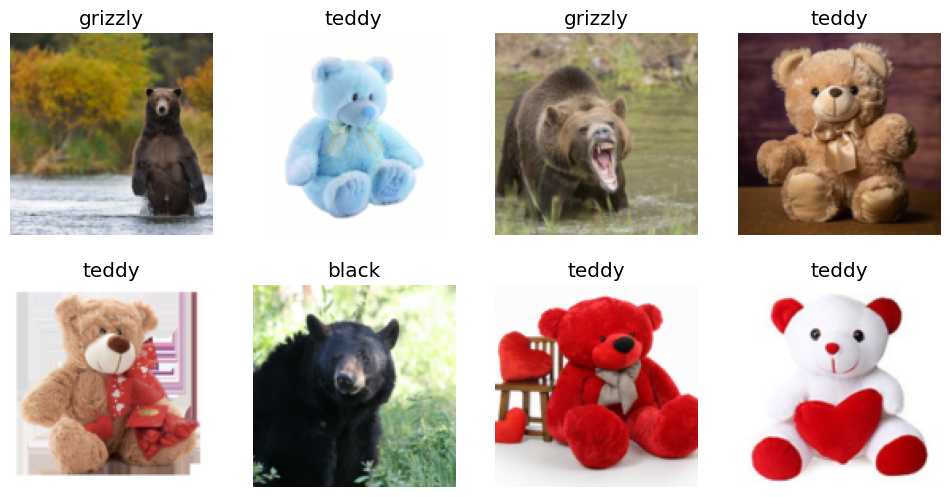

In [27]:
dls.valid.show_batch(max_n=8, nrows=2)

### Exploring different `Resize` methods
The default `Resize` method is a crop to fit the size requested, using the full width or height. Other options include:
- Pad: this pads the images with zeros (black) to make the size requested.
- Squish: this squishes or stretches the image to make the size requested.

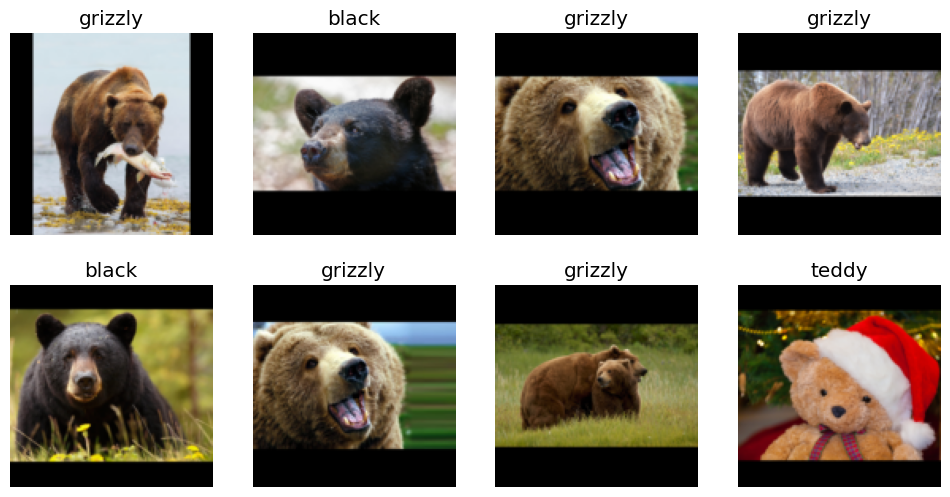

In [ ]:
# Pad Method

bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros')) # this changes some of the variables of the previously defined Datablock template.
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=8, nrows=2)

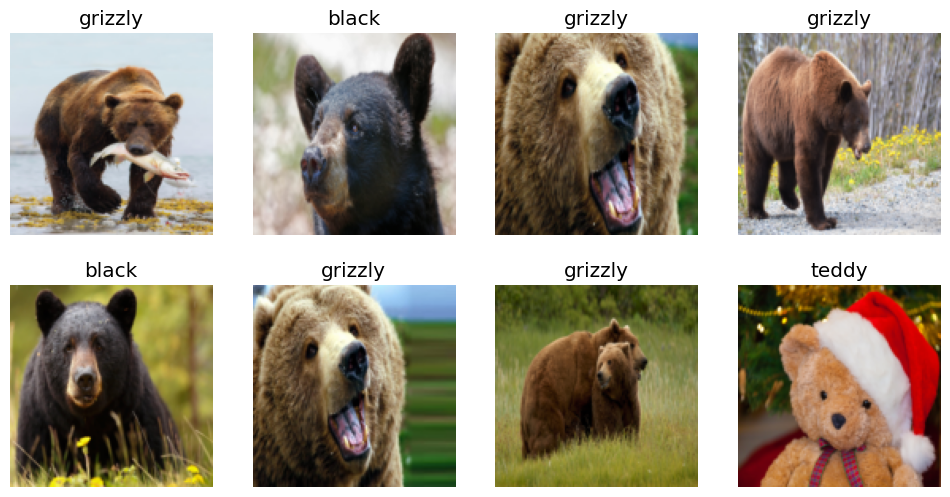

In [ ]:
# Squish Method

bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish)) # this changes some of the variables of the previously defined Datablock template.
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=8, nrows=2)

None of these resize approaches work well.
- Squish: this makes the image take up unrealistic shapes. The model learns that things look different to how they actually are.
- Crop: we might end up losing some key features.
- Pad: this is wasted computation, we end up with lots of empty space.

Best practice
The approach that is usually done in practice is to randomly select part of the image, and crop to just that part. On each epoch, a different part of the image is randomly selcted. This means the model can learn to focus on, and recognise different features in the images. This is also reflective of how images work in the real world, different photos of the same thing may be framed in slightly different ways.

The mwe do this by replacing `Resize` with `RandomResizedCrop`.

epoch = one complet pass through all images in the dataset.

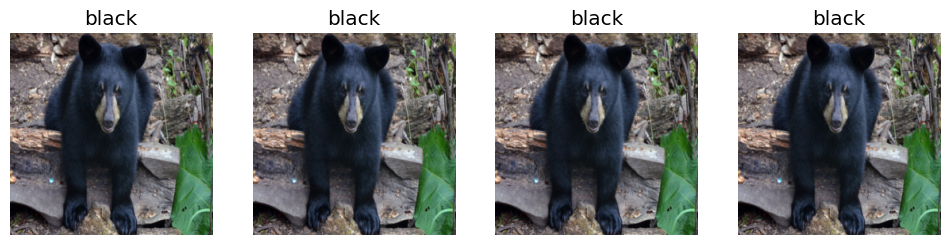

In [35]:
# Random Resized Crop
bears = bears.new(item_tfms=RandomResizedCrop(256)) 
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1, unique=True)


# 2024-05-07 This is not working as expectd. Can't see any cropping.

2024-05-08: Still can't get this to work. Posted in [forums](https://forums.fast.ai/t/lesson-2-official-topic/96033/819?u=errolleesw) for support.

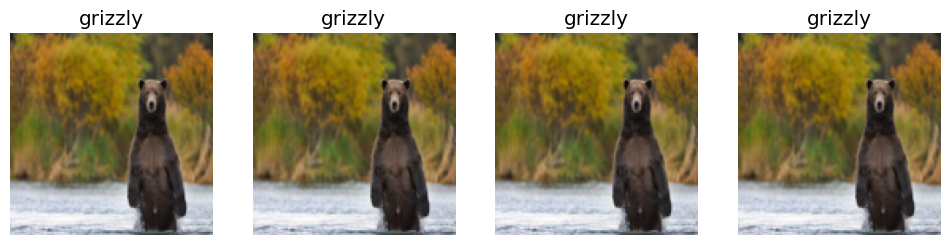

In [45]:
from fastai.vision.all import *
from pathlib import Path

# Assuming you're using fastai library
bears = DataBlock(blocks=(ImageBlock, CategoryBlock),
                  get_items=get_image_files,
                  splitter=RandomSplitter(valid_pct=0.2, seed=42),
                  item_tfms=RandomResizedCrop(128, min_scale=0.3),
                  get_y=parent_label)

dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1, unique=True)


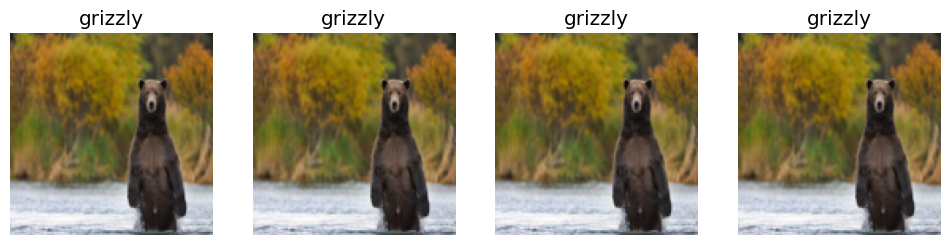

In [51]:
dls.valid.show_batch(max_n=4, nrows=1, unique=True)

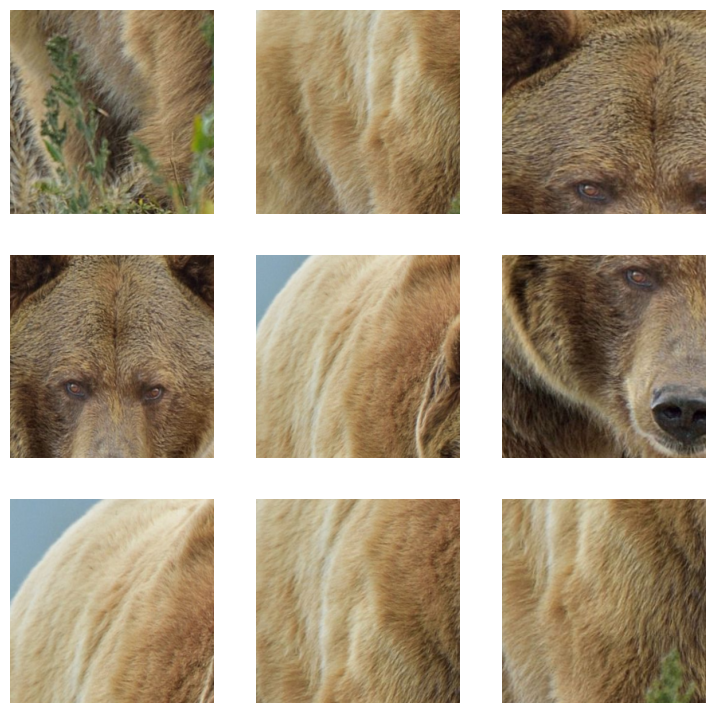

In [38]:
grizzly_bear = PILImage.create('grizzly_bear.jpg')

crop = RandomResizedCrop(256, min_scale=0.05, max_scale=0.15)
_,axs = plt.subplots(3,3,figsize=(9,9))
for ax in axs.flatten():
    cropped = crop(grizzly_bear)
    show_image(cropped, ctx=ax);


In [39]:
from fastai.vision.all import *


# Get the list of image files
images = get_image_files(path)

# Define the transforms
item_tfms = RandomResizedCrop(128, min_scale=0.3)
batch_tfms = Normalize.from_stats(*imagenet_stats)

# Create the data loaders
dls = DataLoaders.from_lists(
    path,
    train_items=images, train_tfms=item_tfms,
    valid_items=images, valid_tfms=item_tfms,
    after_batch=batch_tfms,
    bs=64
)

# Display a batch of validation images
dls.valid.show_batch(max_n=4, nrows=1, unique=True)


AttributeError: type object 'DataLoaders' has no attribute 'from_lists'

In [52]:
! rm -rf image_examples/
! rm -rf people/
! rm -rf bears/
# # ! find bears/grizzly -type f | wc -l\
# ! find bears/teddy -type f | wc -l\
# # ! find bears/teddy -type f | wc -l\

